#### Universidade de Brasília <br> Departamento de Ciência da Computação
# Projeto 1:
### Teoria e Aplicação de Grafos, Turma 01, 2025/1 <br> Prof. Díbio <br> Integrantes do Grupo: Bruno Henrique (221022239), João Victor Prata (202028857), Manuela ()

## Importar Bibliotecas:

In [55]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from networkx.algorithms.community import greedy_modularity_communities
from itertools import combinations
import math

# 1. Coletar Dados:
- Extração dos dados de um dataset real. (https://www.kaggle.com/datasets/mrisdal/fake-news)


In [65]:
# Leitura do CSV com pandas
df = pd.read_csv("fake.csv")
# Aqui podemos remover algumas colunas do dataframe que não nos interessam para essa análise com grafos
colunas_desinteressantes = ['uuid', 'language', 'crawled', 'site_url', 'country', 'domain_rank', 'main_img_url', 'spam_score', 'type']
df = df.drop(columns=colunas_desinteressantes, axis=1)
df = df.dropna(subset=['author'])
# Elementos iniciais do csv
print(df.head())


   ord_in_thread                author                      published  \
0              0     Barracuda Brigade  2016-10-26T21:41:00.000+03:00   
1              0  reasoning with facts  2016-10-29T08:47:11.259+03:00   
2              0     Barracuda Brigade  2016-10-31T01:41:49.479+02:00   
3              0                Fed Up  2016-11-01T05:22:00.000+02:00   
4              0                Fed Up  2016-11-01T21:56:00.000+02:00   

                                               title  \
0  Muslims BUSTED: They Stole Millions In Gov’t B...   
1  Re: Why Did Attorney General Loretta Lynch Ple...   
2  BREAKING: Weiner Cooperating With FBI On Hilla...   
3  PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...   
4  FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...   

                                                text  \
0  Print They should pay all the back all the mon...   
1  Why Did Attorney General Loretta Lynch Plead T...   
2  Red State : \r\nFox News Sunday reported this ...   


# 2. Construir Grafo:

- Representação da rede usando o NetworkX,
- Nós: Usuários.
- Arestas: Retweets/Mentions.
- Pesos: Frequência de interação.

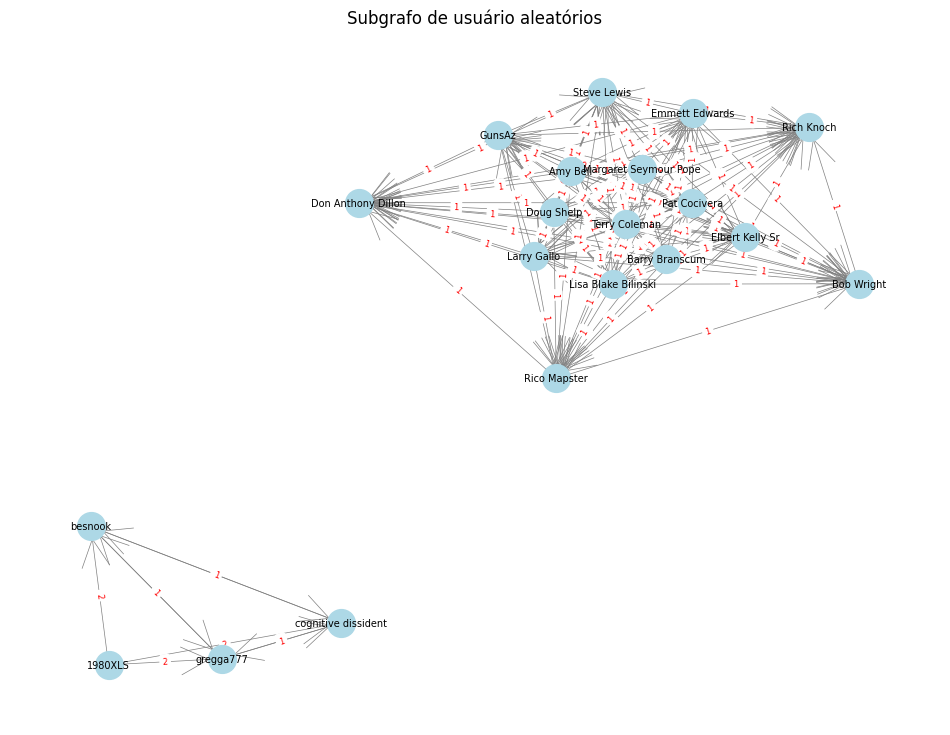

In [86]:
# df.groupby('thread_title') -> Agrupa todo o dataset com base o thread_title
# pode ser descontruído como (thread, grupo) para cada thread presente no dataframe
# Assim, para uma thread x temos todos os autores que estão interagindo sob um tema
G = nx.DiGraph()
for thread, group in df.groupby('thread_title'):
    autores = group['author'].unique()
    for u1, u2 in combinations(autores, 2):
        if G.has_edge(u1, u2):
            G[u1][u2]['weight'] += 1
        else:
            G.add_edge(u1, u2, weight=1)
# Dado a massividade do grafo armazenado em G, para a visualização dele é melhor compreende-lo com base subgrafos
no_aleatorio = sorted(G.degree, key=lambda x: x[1], reverse=True)[:20]
no_aleatorio = [n for n, _ in no_aleatorio]
subG = G.subgraph(no_aleatorio)

plt.figure(figsize=(12, 9))
pos = nx.spring_layout(subG, k=0.8, iterations=50)

# nós
nx.draw_networkx_nodes(subG, pos, node_color='lightblue', node_size=400)

# arestas com setas (direção)
nx.draw_networkx_edges(
    subG, pos,
    arrowstyle='->',
    arrowsize=50,
    edge_color='gray',  
    width=0.5
)
# labels dos nós
nx.draw_networkx_labels(subG, pos, font_size=7)

# pegar pesos das arestas (se tiver)
edge_labels = nx.get_edge_attributes(subG, 'weight')

# desenhar pesos perto das arestas, em vermelho para destacar
nx.draw_networkx_edge_labels(subG, pos, edge_labels=edge_labels, font_color='red', font_size=6)
plt.title("Subgrafo de usuário aleatórios")
plt.axis('off')
plt.show()

# 3. Aplicação de Algoritmos

## 3.1 Algoritmo Pagerank
O pagerank é um algoritmo criado pelos cofundadores do Google, utilizado no sistema de busca do google e funciona com base tentar entender a relevância e importância de determinadas páginas web. No nosso contexto, será avaliado a importância e relevância de cada nó. Aplicando o pagerank no grafo completo se obtém os nós mais influentes dessa rede. O código abaixo mostra exatamente isso.


In [87]:
# Pagerank no Grafo obtido do dataset
# O pagerank implementado pela bib nx é feito com base os parametros:
# pagerank(G: Grafo, alpha: Fator de Amortecimento, max_iter: Maximo de iterações, tol: Tolerância para convergencia)
# Onde, o único parametro obrigatório é o Grafo, todos os outros tem valores default caso não sejam inseridos
pagerank = nx.pagerank(G, alpha=0.85)
print(pagerank) 

# Na variavel tem o retorno da função, que é um dicionário da forma {nó, valor}
# Cada valor é um score associado ao nó
# Dessa forma, temos no retorno do pagerank que o nó com valor mais alto é o nó mais influente no nosso contexto.

# Filtra o resultado do pagerank para não incluir usuários "nan" nem "admin"
pagerank_filtrado = {n: v for n, v in pagerank.items() if n != 'nan' and n != 'admin' and not (isinstance(n, float) and math.isnan(n))}

# Agora pega o mais influente com o pagerank filtrado
maisInfluente = max(pagerank_filtrado, key=pagerank_filtrado.get)
print("O mais influente da rede: ", maisInfluente)
print("Score do user mais influente: ", pagerank_filtrado[maisInfluente])

{'tokyowashi (noreply@blogger.com)': 0.0007084000717737366, 'Anonymous': 0.002921456391393717, 'Ken Kurson': 0.0007084000717737366, 'Steve Watson': 0.0025882026670936546, 'Daisy Luther': 0.0007084000717737366, 'Editor': 0.006919537464119529, 'Activist Post': 0.0008589549846700732, 'hqanon': 0.0007449097326380403, 'OZbanislam': 0.0013939918372750586, 'Heather Callaghan': 0.0029513667867101185, 'noreply@blogger.com (Alexander Light)': 0.0010290659208181977, 'ecclesiatical': 0.0007084000717737366, 'Enjoykin4': 0.001588637496490421, 'Martin': 0.0007337304100028315, 'shorty': 0.00806593596826885, 'Eric Zuesse.': 0.004738754151134332, 'wmw_admin': 0.0020064166224266697, 'Pat Buchanan': 0.0010499240015731928, 'PatriotRising': 0.0009091399556355186, 'Ryan Banister': 0.0012660052827213068, 'Madeline': 0.00167151611329332, 'Kantucky': 0.0009137108199078305, 'Arnold Monteverde (noreply@blogger.com)': 0.00090281302049909, 'David Swanson': 0.0007084000717737366, 'DavidSwanson': 0.002579710585817048

# 3.2 Detecção de comunidade
- Louvain ou Girvan-Newman

### Louvain 
Funciona com base duas etapas:
- Otimização Local da Modularidade
- Agregação de Comunidades

### Girvan-Newman
- Calcular a centralidade de Intermediação
- Remover a aresta com maior centralidade
- Recalcular a centralidade
- Repetir os passos até que o grafo se divida nas comunidades desejadas

### Louvain ou Girvan-Newman
Dado que o algoritmo de Girvan-Newman é computacionalmente mais caro, iremos seguir com Louvain. 


! Importante: Louvain é projetado originalmente para lidar com grafos NÃO-Direcionados, como estamos trabalhando em um Dígrafo ele não funcionaria. 
Podemos transformar o grafo em não direcionado para que isso funcione, mas o sentido é alterado, como mostrado abaixo:

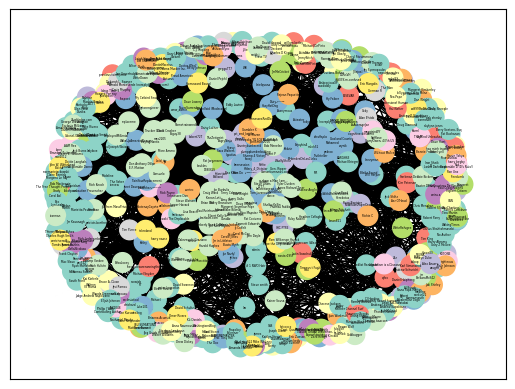

In [89]:
# A biblioteca NetworkX não implementa nativamente o algoritmo de Louvain
import community
# Sabendo que nosso grafo está armazenado em G
part = community.best_partition(G.to_undirected())
size = float(len(set(part.values())))
pos = nx.spring_layout(G, seed=42, k=0.7)  
colors = [part[node] for node in G.nodes()]
nx.draw_networkx(
    G, pos, 
    node_color=colors, 
    with_labels=True, 
    cmap=plt.cm.Set3, 
    node_size=200, 
    font_size=2
)
plt.savefig("grafo_louvain.png", dpi=500, bbox_inches='tight')
plt.show()

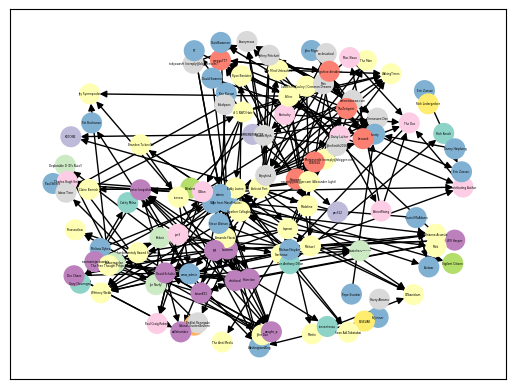

In [91]:
# Podemos também aplicar Louvain a um Subgrafo baseado na centralidade
verticesG = G.number_of_nodes()
centralidade = nx.betweenness_centrality(G)
nosMaiorCentralidade = sorted(centralidade, key=centralidade.get, reverse=True)[:verticesG//5]
subgrafoParaLouvain = G.subgraph(nosMaiorCentralidade)
# Replicação do código de cima para plot das comunidades identificadas com Louvain no subgrafo
part = community.best_partition(subgrafoParaLouvain.to_undirected())
size = float(len(set(part.values())))
pos = nx.spring_layout(subgrafoParaLouvain, seed=42, k=0.7)  
colors = [part[node] for node in subgrafoParaLouvain.nodes()]
nx.draw_networkx(
    subgrafoParaLouvain, pos, 
    node_color=colors, 
    with_labels=True, 
    cmap=plt.cm.Set3, 
    node_size=200, 
    font_size=2
)
plt.savefig("subgrafo_louvain.png", dpi=500, bbox_inches='tight')
plt.show()


# 3.2 Medidas de Centralidade
- Grau de Centralidade (Degree Centrality): Quem compartilha mais?

    Mede a importância de um nó com base o número de conexões diretas, ou de forma simplificada, o grau de um nó dividido pelo número total de nós menos 1:
    $$
    GrauDeCentralidade(v: verticeQualquer) = \frac {adj(v)} {N-1}
    $$
    \
    Onde, adj(v) representa a quantidade de vértices adjacentes de v.
    \
    Implementado no NetworkX como nx.degree_centrality(Grafo), que retorna um dict com todos os nós e seus respectivos graus de centralidade.

- Conexão de Centralidade ou Centralidade de Intermediação (Betweennesss Centrality): Quem conecta diferentes comunidades?

    Mede quantas vezes um nó está no caminho mais curto entre outros pares de nós, ou seja, que servem como pontes nessa rede, em especial, entre comunidades.
    \ 
    É implementado no NetworkX como nx.betweenness_centrality(G) e, assim como o grau de centralidade, retorna um dict com os nós e suas "pontuações".

- Proximidade de Centralidade: Quem pode espalhar mais rapidamente?
    Mede o quão perto um nó está dos outros na rede, no nosso contexto, um nó mais próximo dos outros poderia espalhar mais rapidamente uma fake news.
    \ 
    É implementa no NetworkX como nx.closeness_centrality(G) e retorna um dict dos nós e suas "pontuações".

In [94]:
grauDeCentralidade = nx.degree_centrality(G)
print("Grau de centralidade do grafo: ", grauDeCentralidade)

centralidadeDeIntermediacao = nx.betweenness_centrality(G)
print("Centralidade de Intermediação: ", centralidadeDeIntermediacao)

proximidadeDeCentralidade = nx.closeness_centrality(G)
print("Proximidade de Centralidade: ", proximidadeDeCentralidade)

# Agora podemos respoder as perguntas propostas em cada uma das medidas:
maioresCentralidades = sorted(grauDeCentralidade.items(), key=lambda x: x[1], reverse=True)[:5]
maioresCentralidadesIntermediacao = sorted(centralidadeDeIntermediacao.items(), key=lambda x: x[1], reverse=True)[:5]
maioreProximidades = sorted(proximidadeDeCentralidade.items(), key=lambda x: x[1], reverse=True)[:5]
print("")
print("Maiores Centralidades (Quem compartilha mais?): ")
for i in range(5):
    print(f"{i+1}: {maioresCentralidades[i]}")
print("")
print("Maiores Centralidades de Intermediação (Quem conecta diferentes comunidades?): ")
for i in range(5):
    print(f"{i+1}: {maioresCentralidadesIntermediacao[i]}")
print("")
print("Maiores Centralidades (Quem pode espalhar mais rapidamente?): ")
for i in range(5):
    print(f"{i+1}: {maioreProximidades[i]}")

Grau de centralidade do grafo:  {'tokyowashi (noreply@blogger.com)': 0.008680555555555556, 'Anonymous': 0.03298611111111111, 'Ken Kurson': 0.001736111111111111, 'Steve Watson': 0.008680555555555556, 'Daisy Luther': 0.005208333333333333, 'Editor': 0.024305555555555552, 'Activist Post': 0.026041666666666664, 'hqanon': 0.03819444444444444, 'OZbanislam': 0.006944444444444444, 'Heather Callaghan': 0.01909722222222222, 'noreply@blogger.com (Alexander Light)': 0.013888888888888888, 'ecclesiatical': 0.001736111111111111, 'Enjoykin4': 0.03125, 'Martin': 0.003472222222222222, 'shorty': 0.029513888888888888, 'Eric Zuesse.': 0.003472222222222222, 'wmw_admin': 0.01909722222222222, 'Pat Buchanan': 0.001736111111111111, 'PatriotRising': 0.006944444444444444, 'Ryan Banister': 0.005208333333333333, 'Madeline': 0.012152777777777776, 'Kantucky': 0.005208333333333333, 'Arnold Monteverde (noreply@blogger.com)': 0.005208333333333333, 'David Swanson': 0.005208333333333333, 'DavidSwanson': 0.00520833333333333

# Visualização
Ao longo de todo o código foi plotado utilizando as bibliotecas NetworkX e MatplotLib para visualização dos grafos e subgrafos utilizados.


# Resultados 
Podemos plotar os graus de distribuição para analisar a estrutura da rede

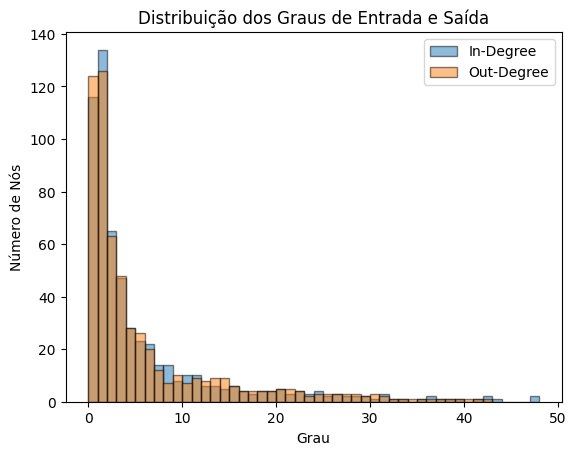

In [96]:
# Dado que é um Dígrafo, temos graus de entrada e saída
grausIn = [d for n, d in G.in_degree()]
grausOut = [d for n, d in G.out_degree()]

plt.hist(grausIn, bins=range(min(grausIn), max(grausIn)+2), alpha=0.5, label='In-Degree', edgecolor='black')
plt.hist(grausOut, bins=range(min(grausOut), max(grausOut)+2), alpha=0.5, label='Out-Degree', edgecolor='black')
plt.legend()
plt.title("Distribuição dos Graus de Entrada e Saída")
plt.xlabel("Grau")
plt.ylabel("Número de Nós")
plt.show()